***importing packages and libraries***

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import RandomBrightness, RandomContrast, RandomZoom
from configs import modelConfigs
import pathlib as pl
import matplotlib.pyplot as plt

In [ ]:
import sys
#ensure numpy and tensorflow are working
print(sys.executable)
print(np.__version__)
print(tf.__version__)

#ensure grpahics cards and CUDA direviers are available
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'


In [3]:
def pre_process_image(image_path, target_height):
    # Load image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=1)  # Decode to grayscale
    
    # Convert image to float32 and normalize to [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)

    shape = tf.shape(image)

    # Convert to numpy array
    h, w, _ = shape.numpy()

    # Calculate new width based on target height
    aspect_ratio = tf.cast(w, tf.float32) / tf.cast(h, tf.float32)
    new_width = tf.cast(target_height * aspect_ratio, tf.int32)

    # Resize image
    image_resized = tf.image.resize(image, [target_height, new_width])

    return image_resized

In [81]:
def build_augmentation_model():
    augmentation_model = tf.keras.Sequential([
        RandomBrightness(factor=(-0.1, 0.1), value_range=(0, 1)),
        RandomContrast(factor=0.05),
        RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2), fill_mode='constant', fill_value=1.0)
        
    ])
    return augmentation_model


In [13]:
#function for inspiration not for actual usage
"""
def input_batch_generator(image_paths, target_height, target_width, batch_size, augmentation_probability=0.2):
    while True:
        batch_images = []
        for image_path in image_paths:
            image = pre_process_image(image_path, target_height)
            if np.random.rand() < augmentation_probability:
                image = augment_image(image)
            if image.shape[1] < target_width:
                pad_width = target_width - image.shape[1]
                image = np.pad(image, ((0, 0), (0, pad_width)), mode='constant', constant_values=1.0)
            else:
                image = image[:, :target_width]
            batch_images.append(image)
            if len(batch_images) == batch_size:
                yield np.array(batch_images)
                batch_images = []
"""


"\ndef input_batch_generator(image_paths, target_height, target_width, batch_size, augmentation_probability=0.2):\n    while True:\n        batch_images = []\n        for image_path in image_paths:\n            image = pre_process_image(image_path, target_height)\n            if np.random.rand() < augmentation_probability:\n                image = augment_image(image)\n            if image.shape[1] < target_width:\n                pad_width = target_width - image.shape[1]\n                image = np.pad(image, ((0, 0), (0, pad_width)), mode='constant', constant_values=1.0)\n            else:\n                image = image[:, :target_width]\n            batch_images.append(image)\n            if len(batch_images) == batch_size:\n                yield np.array(batch_images)\n                batch_images = []\n"

In [ ]:
# build the 2 functions for retrive the necessary image file path for each folder
"""
brainstorm:
batch generator...
batch_generator loops through file paths and feeds that file path into a function that outputs
a tuple with an image path and its associated XML path.

segmenting the loops...
have 2 seperate loops for each folder and varaibles to keep track of the 
final image that was passed into the training batch (to remember the final image placed in the batch).

input and output retrieval for batch generation...


"""


In [75]:
def batch_generator(image_paths , batch_size, target_height, augmentation_probability = 0.3, batch_data_split = (0.4, 0.6)):
    forms_ex = pl.Path(image_paths[0])
    sentence_ex = pl.Path(image_paths[1])
    #keep track of last image from the imageg data base 
    last_image_forms = 0
    last_image_sentence = 0

    forms_tot_num = round(batch_size * batch_data_split[0])
    senetence_tot_num = round(batch_size * batch_data_split[1])
    
    augmentation_model = build_augmentation_model()
    while True:
        batch = [] #initilaise batch array
        
        pos_counter = 0
        for image_path in forms_ex.iterdir(): #loop thorugh the forms array
            # split the batch by the percentage outlined
            if pos_counter == last_image_forms + forms_tot_num + 1:
                #number of forms added
                break
            elif pos_counter >= last_image_forms:
                pos_counter += 1
                #change the imagepath data structure from pathlib structures into string for image preporcessing
                if not isinstance(image_path,str):
                    image_path = str(image_path)
                image = pre_process_image(image_path, target_height)
                if np.random.rand() > augmentation_probability:
                    image = augmentation_model(image)
                batch.append(image)
        break
    #convert batch array into numpy array for tensorflow training 
    return np.array(batch)


In [67]:
# A function written to display a batch
#I used it to ensure batch generator was working alongside the augmentor model

def inpute_batch_displayer(batch):

    num_images = len(batch)
    cols = 5  # Adjust number of columns to fit your needs
    rows = (num_images + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
    axes = axes.flatten()  # Flatten to easily index axes

    for i in range(num_images):
        ax = axes[i]
        ax.imshow(batch[i], cmap='gray')
        ax.axis('off')
        # Add index label on top of each image
        ax.text(0.5, 1.05, str(i), ha='center', va='center', transform=ax.transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

    # Hide any empty subplots
    for i in range(num_images, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


In [82]:
c = modelConfigs()

batch = batch_generator(c.image_paths, c.test_batch_size, c.image_height, c.augmentation_probability, c.data_split)
print(c.test_batch_size)
print(batch)

100
[[[[1.        ]
   [1.        ]
   [1.        ]
   ...
   [1.        ]
   [1.        ]
   [1.        ]]

  [[1.        ]
   [1.        ]
   [1.        ]
   ...
   [1.        ]
   [1.        ]
   [1.        ]]

  [[1.        ]
   [1.        ]
   [1.        ]
   ...
   [1.        ]
   [1.        ]
   [1.        ]]

  ...

  [[1.        ]
   [1.        ]
   [1.        ]
   ...
   [1.        ]
   [1.        ]
   [1.        ]]

  [[1.        ]
   [1.        ]
   [1.        ]
   ...
   [1.        ]
   [1.        ]
   [1.        ]]

  [[1.        ]
   [1.        ]
   [1.        ]
   ...
   [1.        ]
   [1.        ]
   [1.        ]]]


 [[[0.8449678 ]
   [0.8534771 ]
   [0.85813904]
   ...
   [0.8742641 ]
   [0.8707094 ]
   [0.87564576]]

  [[0.847769  ]
   [0.84908223]
   [0.860656  ]
   ...
   [0.8789669 ]
   [0.87844676]
   [0.8790641 ]]

  [[0.8522542 ]
   [0.8560509 ]
   [0.86476696]
   ...
   [0.8831672 ]
   [0.8858315 ]
   [0.8857    ]]

  ...

  [[0.8661165 ]
   [0.87824   ]
   

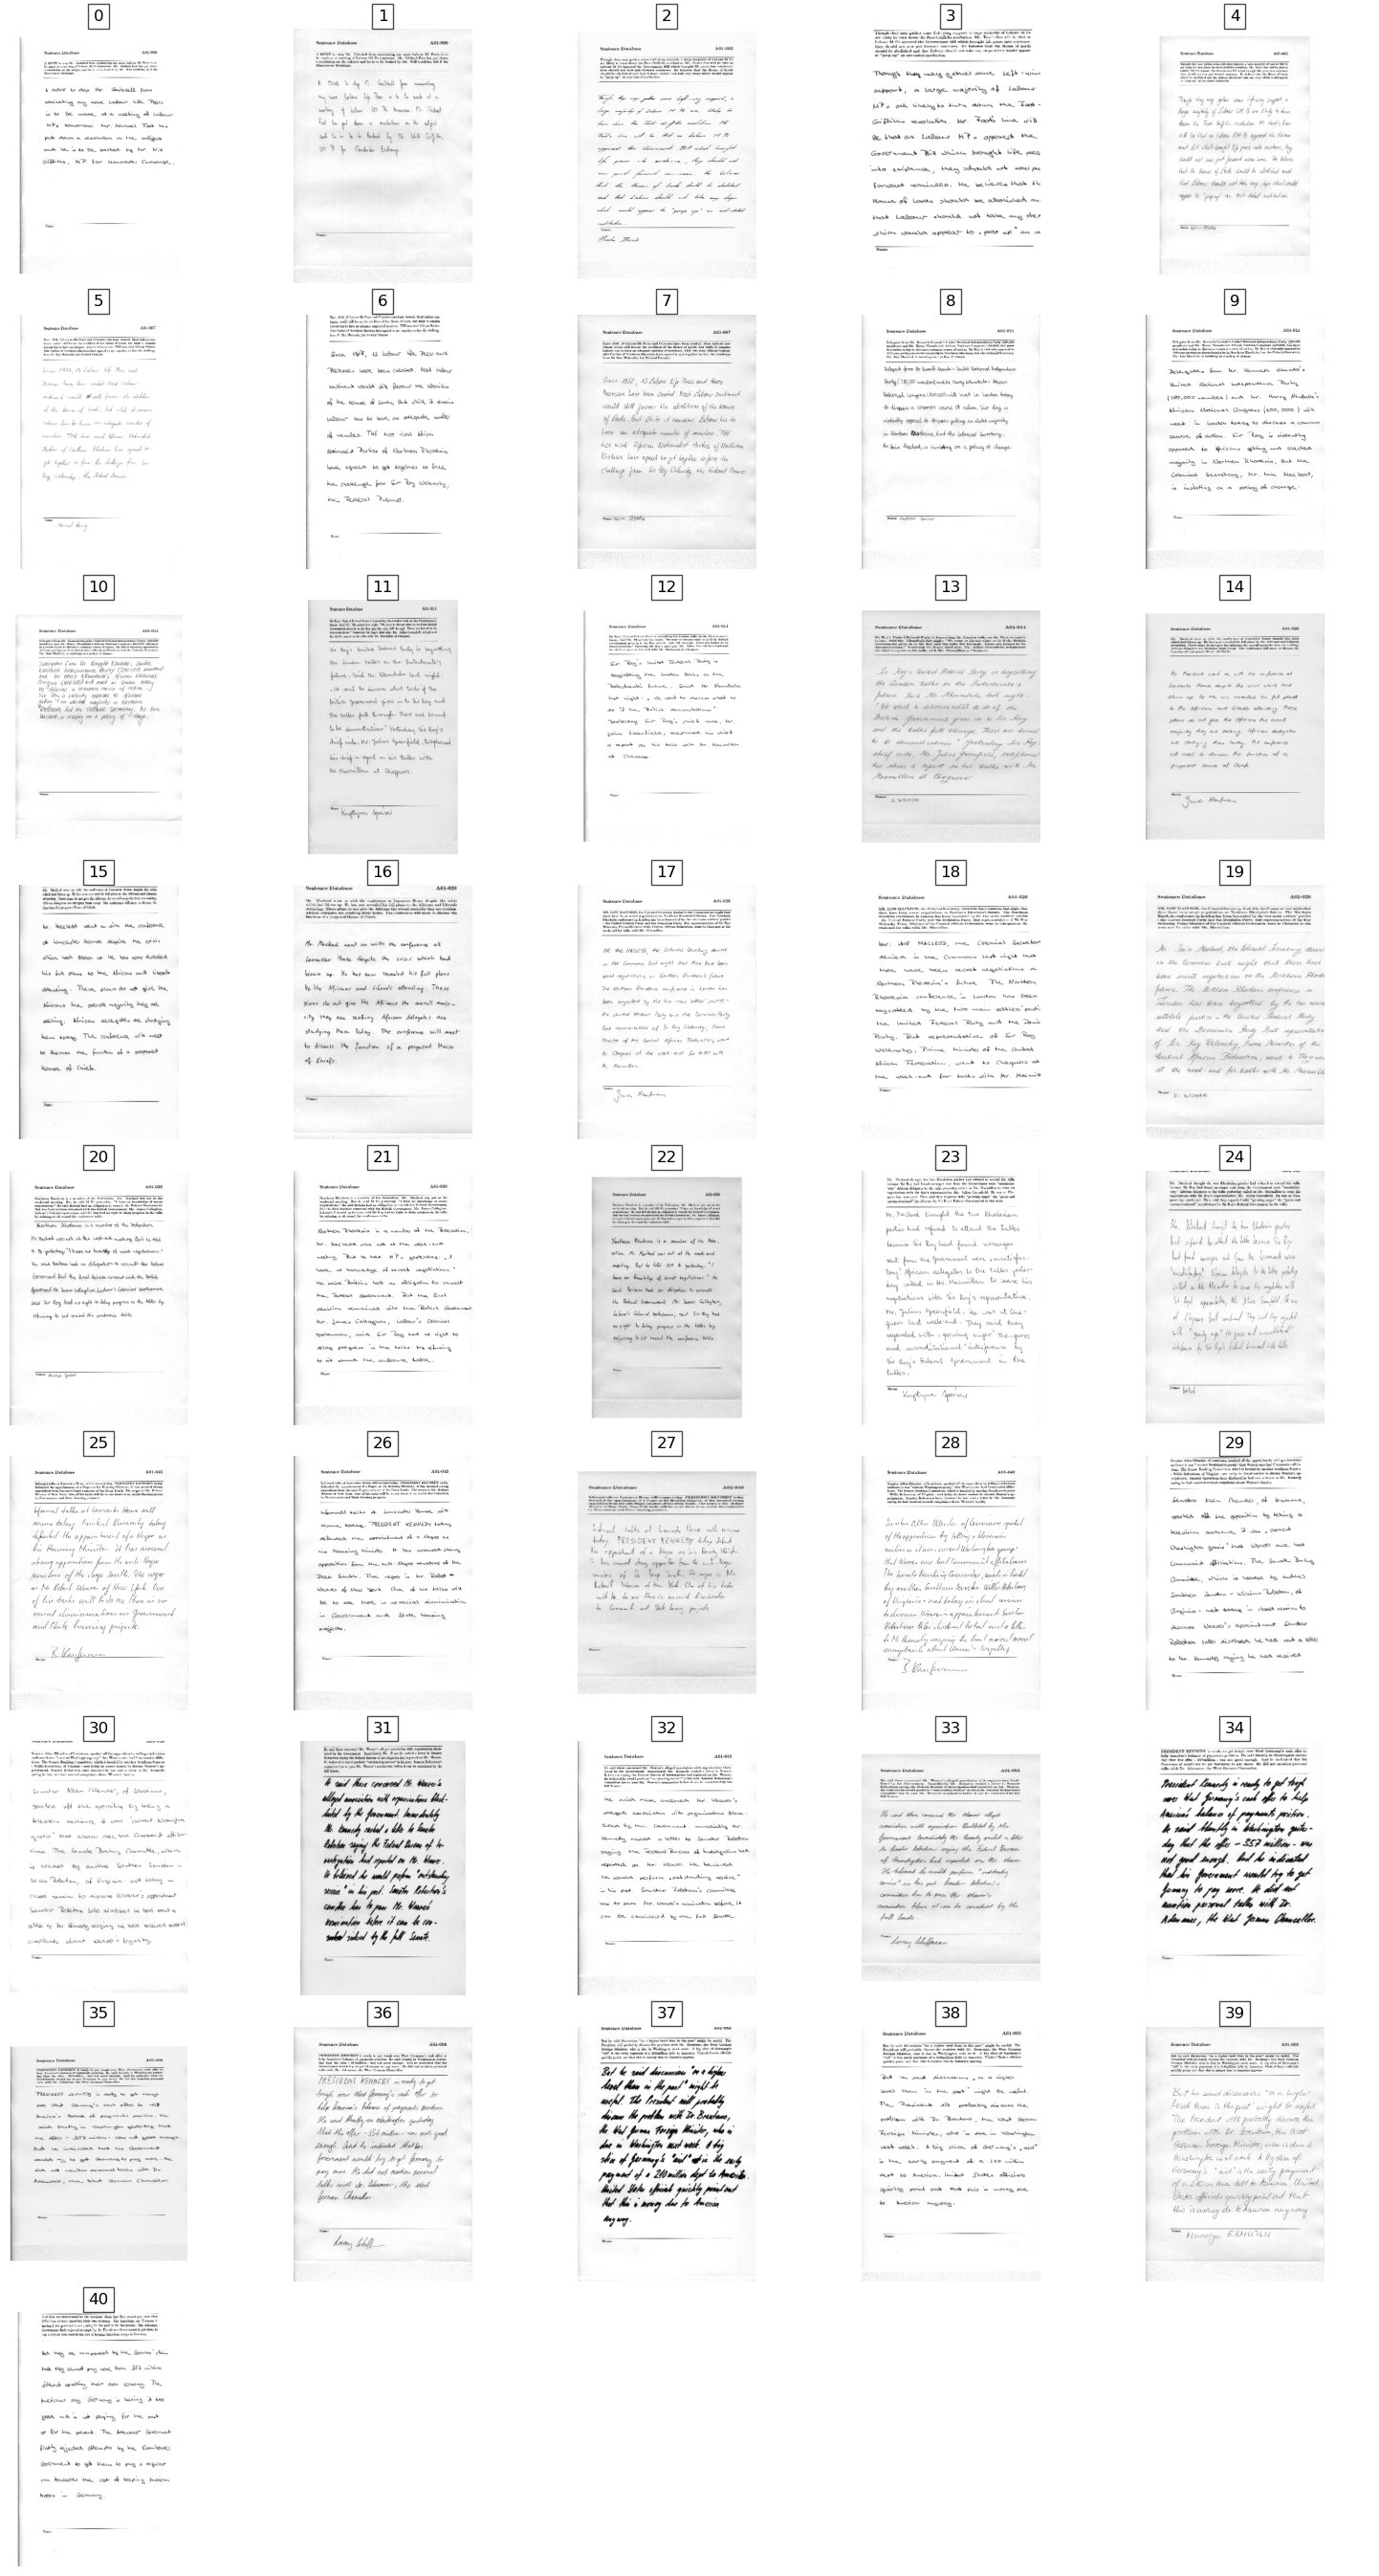

In [83]:
inpute_batch_displayer(batch)